# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image
from numpy import expand_dims,zeros,ones
from numpy.random import randn,randint
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.datasets import mnist
import os

# Setting up basic parameters

In [2]:
IMAGE_SIZE = (28,28,1)
BATCH_SIZE = 200
STEPS = 500
EPOCHS = 20
LATENT_DIM = 100
N_CLASSES = 10

# Fixed Values

Here we are fixing z_vis which is basically a noise vector. At every epoch we will pass this to the generator to see how the generator is improving for the same set of noise.

y_vis is basically a one hot encoded array of out labels (0-9). We will use to see how effective the model is for generating the images of the different labels

In [3]:
z_vis = tf.random.normal([10, LATENT_DIM])
y_vis = tf.constant(np.eye(10), dtype='float32')

# Loading the Dataset

We will load the data from the csv and then reshape it into how the images were.

In [4]:
train_df = pd.read_csv("C:\\Users\\shahm\\Downloads\\digit-recognizer\\train.csv")
y = train_df['label']
train_df.drop('label',axis=1,inplace=True)
training_images=train_df.to_numpy()
training_images = training_images.reshape(42000, 28, 28, 1)

We will be splitting the data into train and test sets. We will then be normalizing our training data for better performance. We will also one hot encode the labels which will improve our training process.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(training_images,y,test_size=0.2)
x_train = x_train / 255.0
y_train = tf.one_hot(y_train, depth=10, dtype='float32')
data_iter = iter(tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(4 * BATCH_SIZE).batch(BATCH_SIZE).repeat())

# Visualize the Data

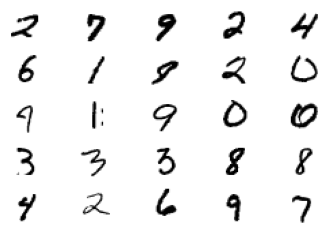

In [6]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray_r')
plt.show()

# Generator

In [7]:
def Generator():
    z = Input(shape=(LATENT_DIM,), dtype='float32')#input for noize vector
    y = Input(shape=(10,), dtype='float32')#input for the label

    x = Concatenate()([z, y])
    x = Dense(7 * 7 * 128)(x)
    x = Reshape((7, 7, 128))(x)

    x = Conv2DTranspose(128, 5, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, 5, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    out = Conv2DTranspose(1,  5, 1, 'same', activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=[z, y], outputs=out)

# Discriminator

In [8]:
def Discriminator():
    X = Input(shape=(28, 28), dtype='float32')#input for real or fake images
    Y = Input(shape=(10,), dtype='float32')#input for the label

    y = tf.tile(tf.reshape(Y,[-1, 1, 1, 10]), [1, 28, 28, 1])
    x = Reshape((28, 28, 1))(X)
    x = Concatenate()([x, y])

    x = Conv2D(32,  5, 2, 'same')(x)

    x = Conv2D(64,  4, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(128,  3, 2, 'same')(x)
    
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)

    out = Dense(1)(x)

    return tf.keras.Model(inputs=[X, Y], outputs=out)

In [9]:
G = Generator()
D = Discriminator()

# Loss Functions

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
def G_loss(D, x_fake, y):
    return cross_entropy(tf.ones_like(D([x_fake, y])), D([x_fake, y]))
def D_loss(D, x_real, x_fake, y):
    return cross_entropy(tf.ones_like(D([x_real, y])), D([x_real, y])) + cross_entropy(tf.zeros_like(D([x_fake, y])), D([x_fake, y]))

In [11]:
G_opt = Adam(2e-4,0.5)
D_opt = Adam(2e-4,0.5)

# Function to save images at specific epochs

In [12]:
def generate_and_save_images(model, epoch, noise,label):
    predictions = model([noise,label])

    fig = plt.figure(figsize=(8, 2))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(model([noise,label])[i,:,:] * 255.0)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Custom Training Loop

epoch: 1; G_loss: 0.992433; D_loss: 1.338444


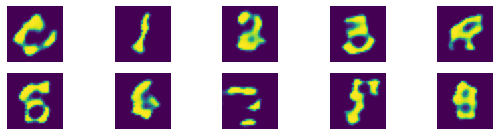

epoch: 2; G_loss: 1.810720; D_loss: 0.862189


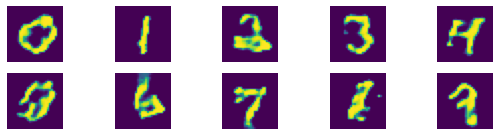

epoch: 3; G_loss: 0.787833; D_loss: 1.239426


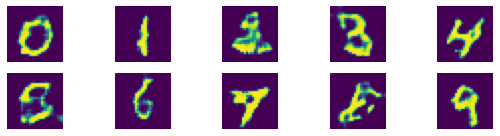

epoch: 4; G_loss: 1.417630; D_loss: 1.324238


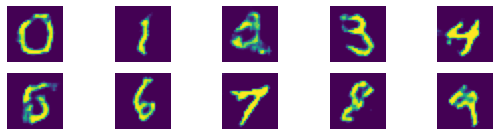

epoch: 5; G_loss: 1.145945; D_loss: 1.121111


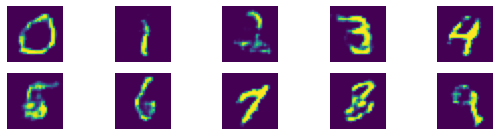

epoch: 6; G_loss: 1.098197; D_loss: 1.222855


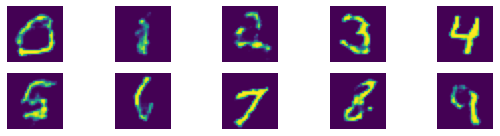

epoch: 7; G_loss: 0.843614; D_loss: 1.191971


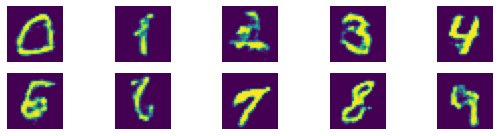

epoch: 8; G_loss: 0.826735; D_loss: 1.235356


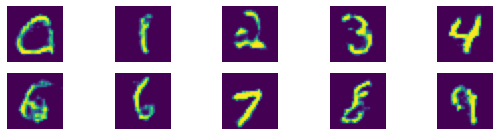

epoch: 9; G_loss: 0.720028; D_loss: 1.259086


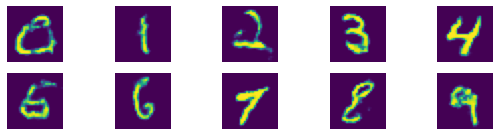

epoch: 10; G_loss: 0.775063; D_loss: 1.279169


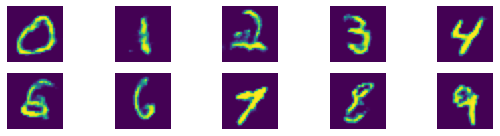

epoch: 11; G_loss: 0.804613; D_loss: 1.310735


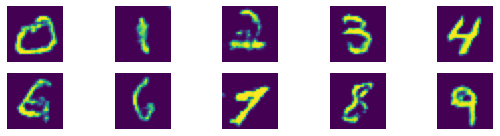

epoch: 12; G_loss: 0.951203; D_loss: 1.244481


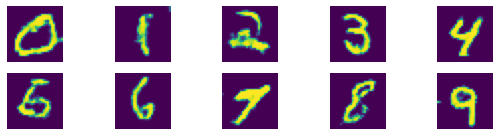

epoch: 13; G_loss: 0.765216; D_loss: 1.285613


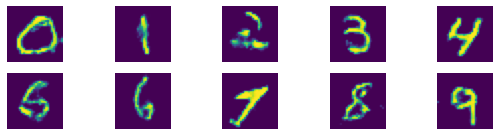

epoch: 14; G_loss: 0.863122; D_loss: 1.308069


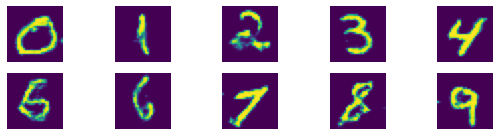

epoch: 15; G_loss: 0.910245; D_loss: 1.318104


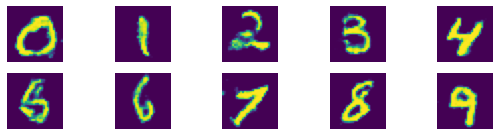

epoch: 16; G_loss: 0.827219; D_loss: 1.388013


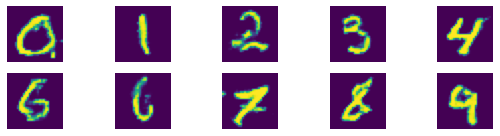

epoch: 17; G_loss: 0.798011; D_loss: 1.280089


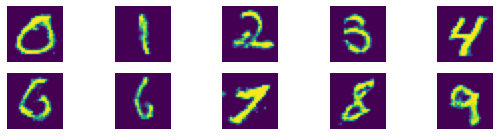

epoch: 18; G_loss: 0.897693; D_loss: 1.269255


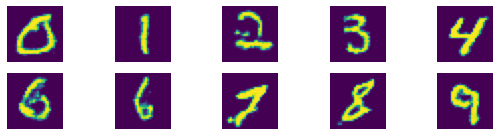

epoch: 19; G_loss: 0.800868; D_loss: 1.391374


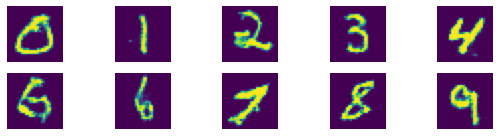

epoch: 20; G_loss: 0.790414; D_loss: 1.349847


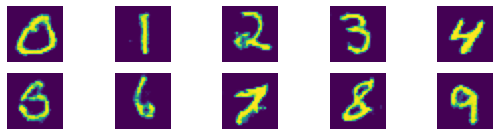

In [13]:
for epoch in range(EPOCHS):
    for step in range(STEPS):
        z_mb = tf.random.normal([BATCH_SIZE, LATENT_DIM])
        x_real, y = next(data_iter)
        with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:  
            x_fake = G([z_mb, y])
            G_loss_curr = G_loss(D, x_fake, y)
            D_loss_curr = D_loss(D, x_real, x_fake, y)

        G_grad = G_tape.gradient(G_loss_curr, G.trainable_variables)
        D_grad = D_tape.gradient(D_loss_curr, D.trainable_variables)

        G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
        D_opt.apply_gradients(zip(D_grad, D.trainable_variables))
    print('epoch: {}; G_loss: {:.6f}; D_loss: {:.6f}'.format(epoch+1, G_loss_curr, D_loss_curr))
    generate_and_save_images(G,epoch,z_vis,y_vis)

# Evaluation

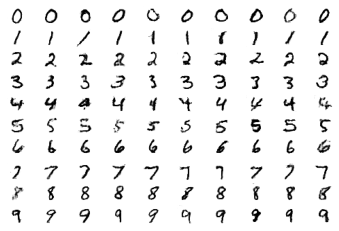

In [14]:
new_noise = tf.random.normal([100, LATENT_DIM])
labels = np.asarray([np.eye(10)[i//10] for i in range(100)])
pred = G([new_noise,labels])
for i in range(100):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(pred[i, :, :], cmap='gray_r')
plt.show()

# Save the images generated during training as a gif

In [15]:
fp_in = "./image_*.png"
fp_out = "./MNIST_training.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

# Save the models for future use

In [16]:
G.save('mnist_gen.hdf5')
D.save('mnist_dis.hdf5')